<a href="https://colab.research.google.com/github/Juliarty/kdd-project/blob/main/Kdd_eyes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Подготовка данных и модели.

В качестве данных взят датасет https://www.kaggle.com/pavelbiz/eyes-rtte, который представляет собой набор изображений мужских и женских глаз. Также в данном ноутбуке используется модель, обученная с использованием кода из https://www.kaggle.com/davidbroberts/male-or-female-eyes-simple-cnn.

In [ ]:
!gdown --id 1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF 

Downloading...
From: https://drive.google.com/uc?id=1A8ACXIBt9vYncvjOkeHz3bYraZsDXMXF
To: /content/eyes-rtte-train-test-split.zip
100% 43.1M/43.1M [00:00<00:00, 163MB/s]


In [ ]:
!unzip -q -n eyes-rtte-train-test-split.zip

In [ ]:
# Do imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



In [ ]:
# Setup some config variables
batch_size = 50
image_size = (256,256)
base_path = './data'
test_path = base_path + '/test'
train_path = base_path + '/train'

seed = 42

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size = image_size,
    batch_size = batch_size,
)

Found 1154 files belonging to 2 classes.


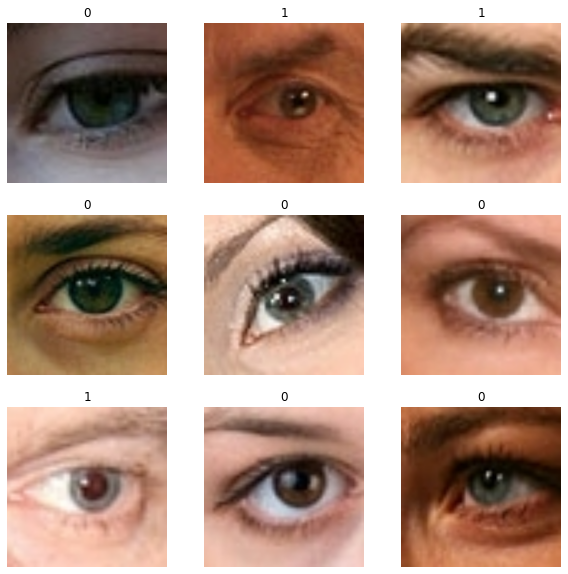

In [ ]:
# Display a few images, label 0 is female, label 1 is male
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = inputs
    #x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=1.0)(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        #x = layers.Activation("relu")(x)
        x = layers.ReLU(max_value=1.0)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU(max_value=1.0)(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU(max_value=1.0)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 32  896         ['rescaling_4[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
# download the trained model
!mkdir model
!cd model
!gdown --id 1iwcQx4WLNJY3PCGEI-YYd3pfWsq9xPjP -O model/model_parameters.h5

mkdir: cannot create directory ‘model’: File exists
Downloading...
From: https://drive.google.com/uc?id=1iwcQx4WLNJY3PCGEI-YYd3pfWsq9xPjP
To: /content/model/model_parameters.h5
100% 33.6M/33.6M [00:00<00:00, 54.7MB/s]


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.load_weights('./model/model_parameters.h5')

In [ ]:
#loss, acc = model.evaluate(test_ds, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

#1. Поиск примеров.

In [ ]:
# Returns the probability vector
def predict_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    return model.predict(img_array)[0]

In [ ]:
from glob import glob
female_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/femaleeyes/*')}

In [ ]:
male_img_to_prediction = {file_path: predict_image(file_path) for file_path in glob('data/test/maleeyes/*')}

In [ ]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

def show_image(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    img_array = tf.expand_dims(img_array, 0)

    # Predict & score
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image is %.2f percent female and %.2f percent male." % (100 * score[0], 100 * score[1]))
    plt.imshow(img);

In [ ]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу

import numpy as np
def get_example(img_to_prediction, closest_to, greater_than=0, less_than=1):
  for item in img_to_prediction.items():
    img = item[0]
    male_prob = item[1][1]
    dist = np.abs(closest_to - male_prob)

    if male_prob <= less_than and greater_than <= male_prob:
      break

  for item in img_to_prediction.items():
    male_prob = item[1][1]
    if np.abs(closest_to - male_prob) < dist \
    and male_prob >= greater_than and male_prob <= less_than:
        img = item[0]
        dist = np.abs(closest_to - male_prob)

  return img


This image is 1.01 percent female and 98.99 percent male.


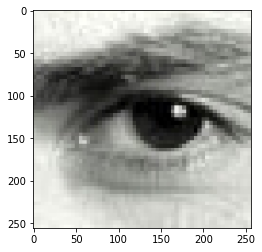

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
true_high_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.99)
show_image(true_high_male_img_path)

This image is 98.94 percent female and 1.06 percent male.


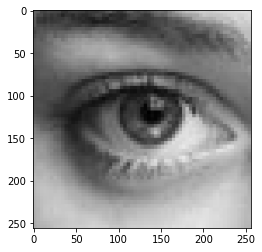

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
true_high_female_img_path = get_example(female_img_to_prediction, 0, 0.01, 0.5)
show_image(true_high_female_img_path)

This image is 40.06 percent female and 59.94 percent male.


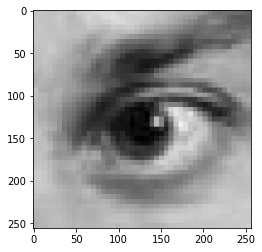

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
true_low_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.6)
show_image(true_low_male_img_path)


This image is 59.74 percent female and 40.26 percent male.


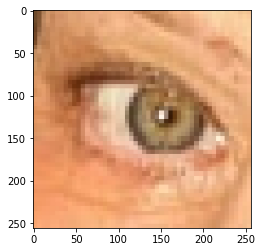

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
true_low_female_img_path = get_example(female_img_to_prediction, 0, 0.4, 0.5)
show_image(true_low_female_img_path)


This image is 99.60 percent female and 0.40 percent male.


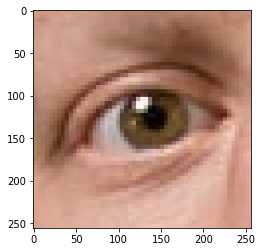

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
false_lowest_male_img_path = get_example(male_img_to_prediction, 0, 0, 0.5)
show_image(false_lowest_male_img_path)

This image is 0.91 percent female and 99.09 percent male.


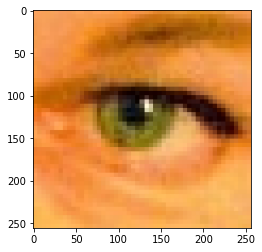

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
false_lowest_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 1)
show_image(false_lowest_female_img_path)

This image is 59.82 percent female and 40.18 percent male.


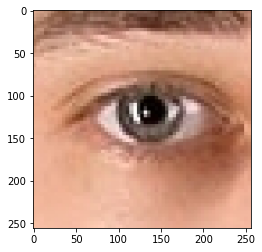

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
false_low_male_img_path = get_example(male_img_to_prediction, 0, 0.4, 0.5)
show_image(false_low_male_img_path)

This image is 40.48 percent female and 59.52 percent male.


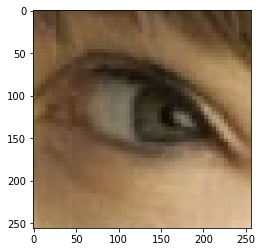

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
false_low_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 0.6)
show_image(false_low_female_img_path)

# 3. Применение методов объяснения нейронных сетей.


## 3.1. Применение метода Gradients.


In [ ]:
LAYER_NAME='separable_conv2d_35'

gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer(LAYER_NAME).output]
)
# and then select the layers having activations
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

In [ ]:
def get_img_array(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Image needs to be in the form of a batch
    return tf.expand_dims(img_array, 0)

In [ ]:
def backprop_method(image_path, relu_gradient=None):
  if relu_gradient is not None:
    for layer in layer_dict:
      layer.activation = relu_gradient
        
  source_img_array = get_img_array(image_path)
  with tf.GradientTape() as tape:
      inputs = tf.cast(source_img_array, tf.float32)
      tape.watch(inputs)
      outputs = gb_model(inputs)[0]
  grads = tape.gradient(outputs, inputs)[0]

  result_grads = grads
  gb_viz = np.dstack((
              result_grads[:, :, 0],
              result_grads[:, :, 1],
              result_grads[:, :, 2],
          )) 

  gb_viz -= np.min(gb_viz)
  gb_viz /= gb_viz.max()
  source_img = keras.preprocessing.image.load_img(image_path, target_size=image_size)

  fig, axarr = plt.subplots(1, 2)
  fig.set_size_inches(10.5, 7.5)
  axarr[0].imshow(gb_viz)
  axarr[1].imshow(source_img)
  plt.show()

In [ ]:
@tf.custom_gradient
def Grad(x):
    def grad(dy):
        return tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

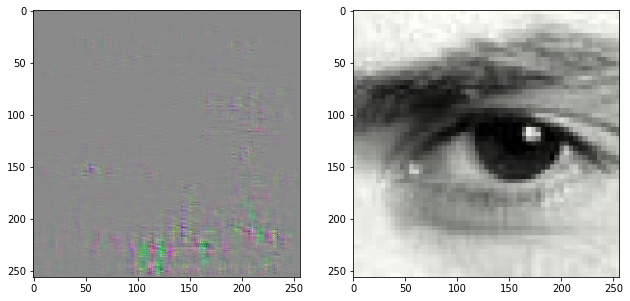

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(true_high_male_img_path, Grad)

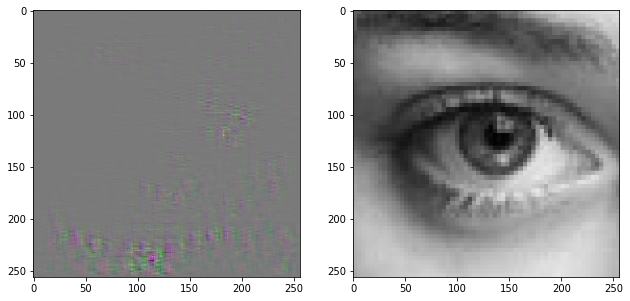

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(true_high_female_img_path, Grad)

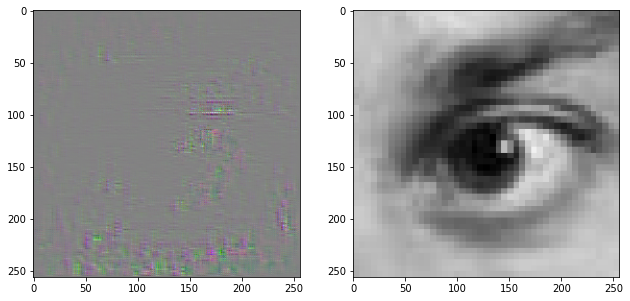

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(true_low_male_img_path, Grad)

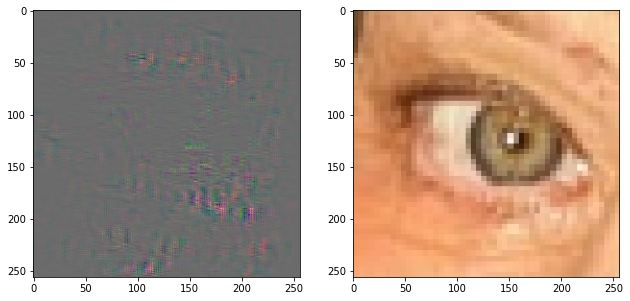

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(true_low_female_img_path, Grad)

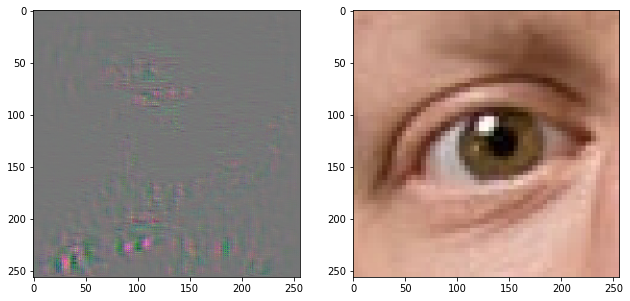

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_male_img_path, Grad) 

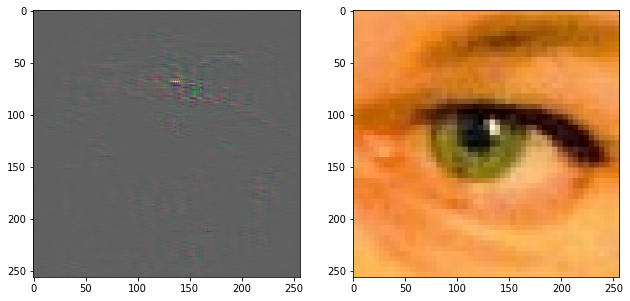

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_female_img_path, Grad)

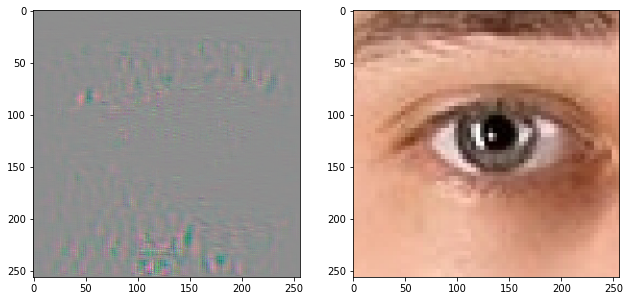

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(false_low_male_img_path, Grad)

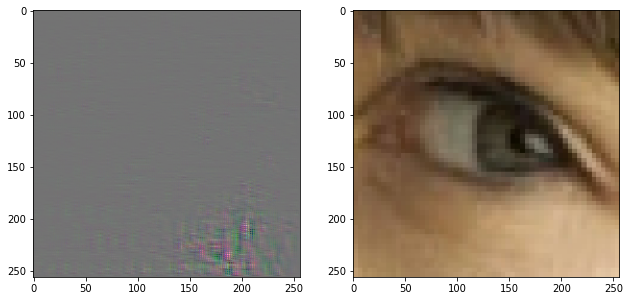

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(false_low_female_img_path, Grad)

## 3.2. Применение метода Guided Backpropagation.

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

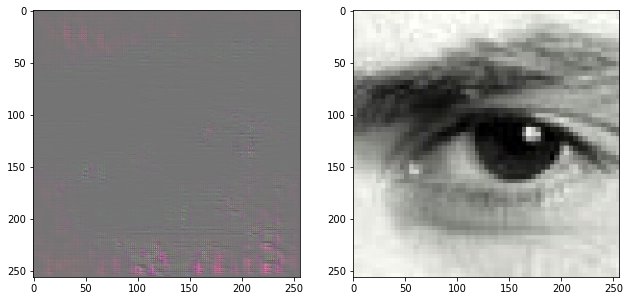

In [ ]:
# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(true_high_male_img_path, guidedRelu)

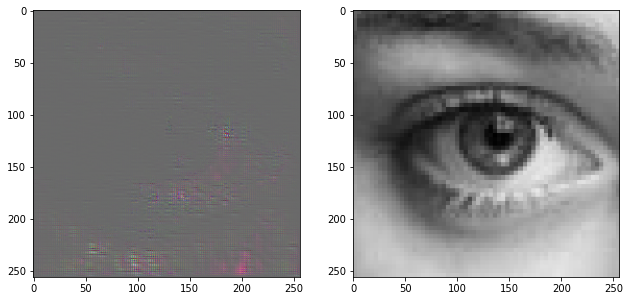

In [ ]:
# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(true_high_female_img_path, guidedRelu)

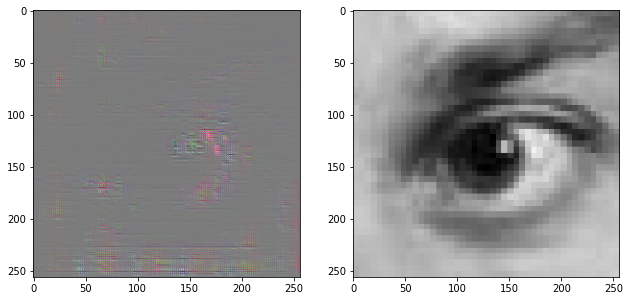

In [ ]:
# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(true_low_male_img_path, guidedRelu)

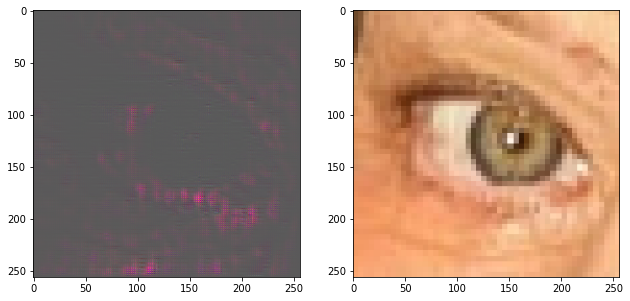

In [ ]:
# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(true_low_female_img_path, guidedRelu)

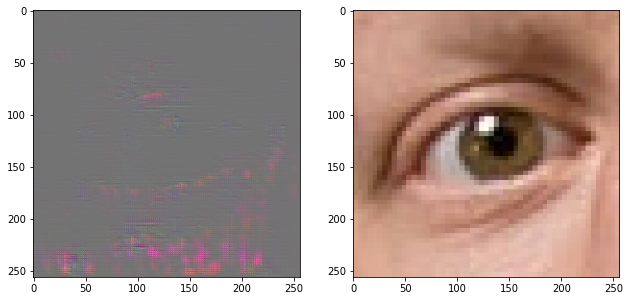

In [ ]:
# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_male_img_path, guidedRelu) 

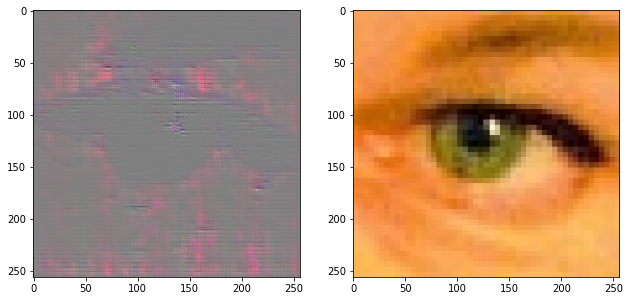

In [ ]:
# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
backprop_method(false_lowest_female_img_path, guidedRelu) 

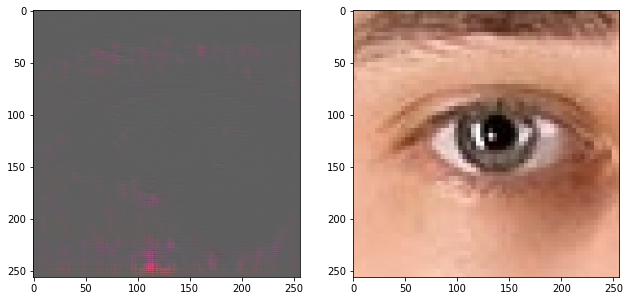

In [ ]:
# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
backprop_method(false_low_male_img_path, guidedRelu)

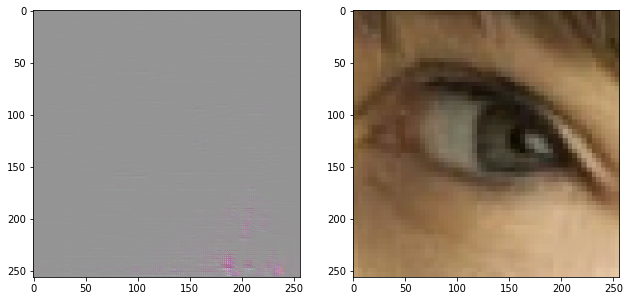

In [ ]:
# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
backprop_method(false_low_female_img_path, guidedRelu)

## 3.3. Применение метода Integrated Gradients.

In [14]:
def get_image_array(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    return img_array / 255

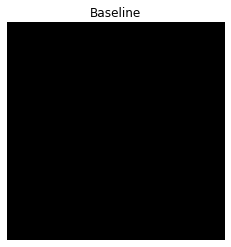

In [15]:
baseline = tf.zeros(shape=(*image_size, 3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()


In [16]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps + 1)

In [17]:
def interpolate_images(baseline, image, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x + alphas_x * delta
  return images

In [20]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=get_image_array(true_high_male_img_path),
    alphas=alphas)


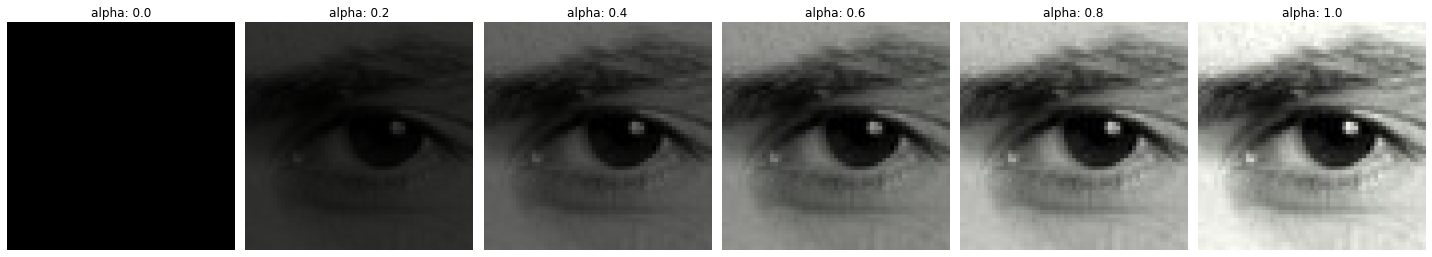

In [21]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


In [22]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [23]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0)


In [24]:
print(path_gradients.shape)

(51, 256, 256, 3)


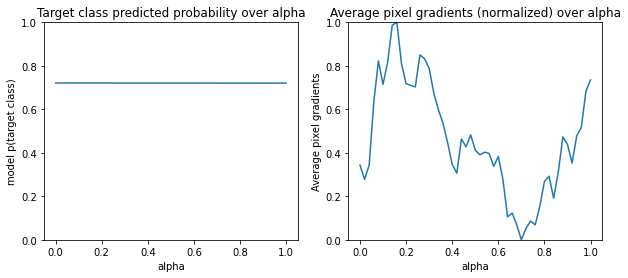

In [25]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 1]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);


In [26]:
pred_proba

<tf.Tensor: shape=(51,), dtype=float32, numpy=
array([0.72106683, 0.72106004, 0.72105336, 0.7210467 , 0.72103983,
       0.721033  , 0.7210261 , 0.72101915, 0.72101223, 0.7210052 ,
       0.7209982 , 0.72099113, 0.72098404, 0.7209768 , 0.72096956,
       0.72096235, 0.72095513, 0.7209479 , 0.7209406 , 0.72093326,
       0.72092587, 0.72091836, 0.72091085, 0.72090334, 0.7208959 ,
       0.72088844, 0.720881  , 0.72087336, 0.7208656 , 0.720858  ,
       0.7208504 , 0.7208428 , 0.7208352 , 0.7208277 , 0.7208203 ,
       0.72081274, 0.7208053 , 0.7207978 , 0.7207903 , 0.72078276,
       0.72077525, 0.72076774, 0.72076035, 0.72075284, 0.7207453 ,
       0.7207378 , 0.7207302 , 0.7207225 , 0.7207147 , 0.72070694,
       0.72069913], dtype=float32)>

In [27]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [28]:
ig = integral_approximation(
    gradients=path_gradients)

In [29]:
print(ig.shape)

(256, 256, 3)


In [30]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps + 1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [31]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=get_image_array(true_high_male_img_path),
                                       target_class_idx=1,
                                       m_steps=120)


In [32]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

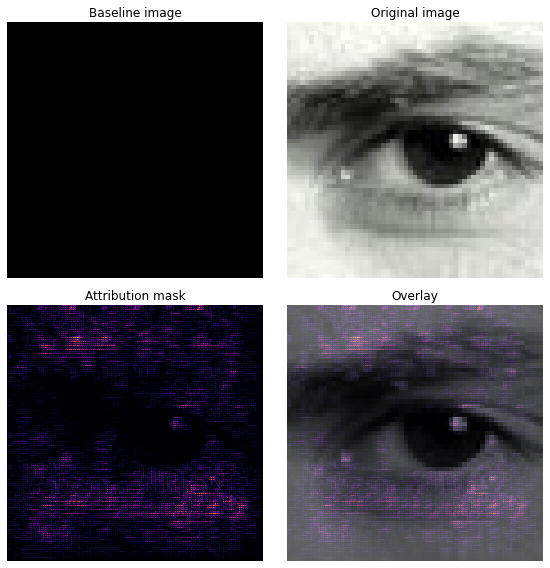

In [33]:
_ = plot_img_attributions(image=get_image_array(true_high_male_img_path),
                          baseline=baseline,
                          target_class_idx=1,
                          m_steps=120,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

In [34]:
images_descriptions = []

# правильно классифицированный мужчина с высокой вероятностью принадлежности к классу
true_high_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.99)
images_descriptions.append((true_high_male_img_path, 'правильно мужчина', 'высокая вероятность'))

# правильно классифицированная женщина с высокой вероятностью принадлежности к классу
true_high_female_img_path = get_example(female_img_to_prediction, 0, 0.01, 0.5)
images_descriptions.append((true_high_female_img_path, 'правильно женщина', 'высокая вероятность'))

# правильно классифицированный мужчина с низкой вероятностью принадлежности к классу
true_low_male_img_path = get_example(male_img_to_prediction, 1, 0.5, 0.6)
images_descriptions.append((true_low_male_img_path, 'правильно мужчина', 'низкая вероятность'))

# правильно классифицированная женщина с низкой вероятностью принадлежности к классу
true_low_female_img_path = get_example(female_img_to_prediction, 0, 0.4, 0.5)
images_descriptions.append((true_low_female_img_path, 'правильно женщина', 'низкая вероятность'))

# неправильно классифицированный мужчина с высокой вероятностью принадлежности к классу
false_lowest_male_img_path = get_example(male_img_to_prediction, 0, 0, 0.5)
images_descriptions.append((false_lowest_male_img_path, 'неправильно мужчина', 'высокая вероятность'))

# неправильно классифицированная женщина с высокой вероятностью принадлежности к классу
false_lowest_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 1)
images_descriptions.append((false_lowest_female_img_path, 'неправильно женщина', 'высокая вероятность'))

# неправильно классифицированный мужчина с низкой вероятностью принадлежности к классу
false_low_male_img_path = get_example(male_img_to_prediction, 0, 0.4, 0.5)
images_descriptions.append((false_low_male_img_path, 'неправильно мужчина', 'низкая вероятность'))

# неправильно классифицированная женщина с низкой вероятностью принадлежности к классу
false_low_female_img_path = get_example(female_img_to_prediction, 1, 0.5, 0.6)
images_descriptions.append((false_low_female_img_path, 'неправильно женщина', 'низкая вероятность'))


In [35]:
text2class = {
    'правильно мужчина':1,
    'неправильно мужчина':0,
    'правильно женщина':0,
    'неправильно женщина':1,
}

In [36]:
def plot_images_attributions(baseline,
                          images_descriptions,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  fig, axs = plt.subplots(nrows=len(images_descriptions), ncols=2, squeeze=False, figsize=(8, 8 * 4))

  for i, (image_path, title1, title2) in enumerate(images_descriptions):
    
    image=get_image_array(image_path)
    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=text2class[title1],
                                      m_steps=m_steps)

    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  
    axs[i, 0].set_title(title1)
    axs[i, 0].imshow(attribution_mask, cmap=cmap)
    axs[i, 0].axis('off')

    axs[i, 1].set_title(title2)
    axs[i, 1].imshow(attribution_mask, cmap=cmap)
    axs[i, 1].imshow(image, alpha=overlay_alpha)
    axs[i, 1].axis('off')

  plt.tight_layout()
  return fig


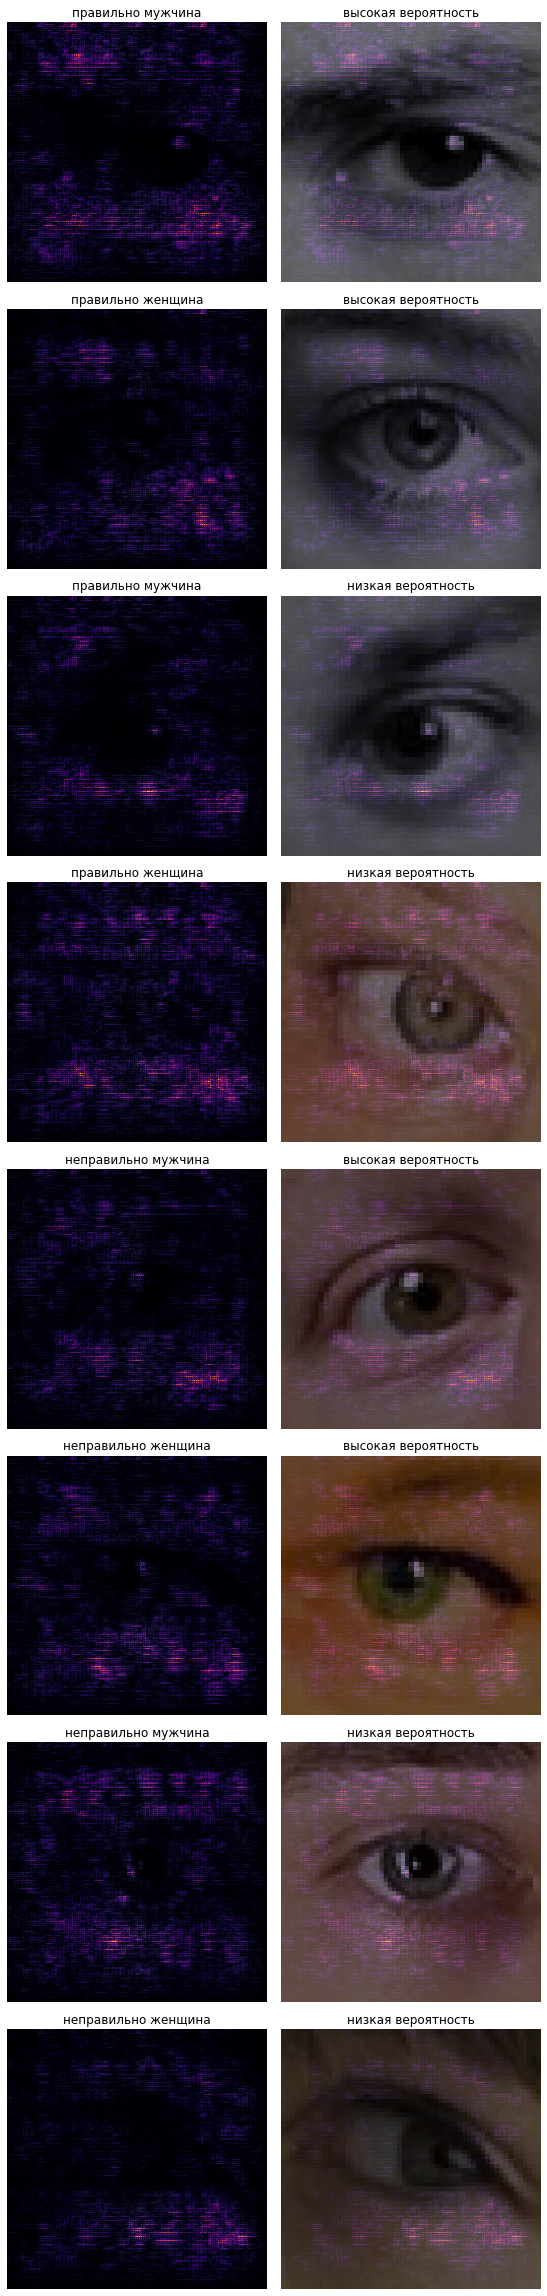

In [37]:
_ = plot_images_attributions(baseline,
                            images_descriptions,
                            m_steps=120,
                            cmap=plt.cm.inferno,
                            overlay_alpha=0.4)